In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import duckdb
from tqdm import tqdm

In [2]:
data_path = '../data'
if os.path.exists(data_path):
    os.chdir(data_path)
    print(f'Change directory to data path: {data_path}')
else:
    print('Please point to the correct data path!')

Change directory to data path: ../data


#### preprocessing data

In [ ]:
# loading data

# standard CRSP exchange codes:
# 1 = NYSE
# 2 = AMEX
# 3 = NASDAQ
# 4 = NYSE Arca (includes SPY)
# 11 = NYSE MKT

con = duckdb.connect()

start_date = '2010-01-01'
end_date = '2012-01-01'

# Query:
# 1. join with delisting adjusted data
# 2. join with market data
# 3. filter by exchange
# 4. make sure the return is not null
query_data = (f"""
    SELECT 
    dsf.permno,
    dlycaldt  AS date,
    dlyret    AS ret,
    shrout    AS shares_outstanding,
    (shrout * dlyprc) AS market_cap,
    mkt_rf,
    rf,
    (ret - rf) AS ret_rf
    FROM read_parquet('crsp_202401.dsf_v2.parquet') AS dsf 
    JOIN (
        SELECT DISTINCT permno, hexcd AS exchange
        FROM read_parquet('crsp_202401.dsenames.parquet')
    ) AS exchanges
    ON dsf.permno = exchanges.permno
    JOIN (
        SELECT dt, mkt_rf, rf
        FROM read_parquet('ff.four_factor.parquet')
    ) AS mkt
    ON dsf.dlycaldt = mkt.dt
    WHERE dlycaldt BETWEEN '{start_date}' AND '{end_date}'
    AND exchange IN (1, 2, 3)
    AND dsf.dlyret IS NOT NULL
""")

crsp_d = con.execute(query_data).fetch_df()
crsp_d['date'] = pd.to_datetime(crsp_d['date'])
con.close()
crsp_d.head(3)

In [ ]:
print(f'Number of unique permnos: {crsp_d["permno"].nunique()}')

#### Run regressions to get beta - multi-process

In [6]:
# calculate the average of the rolling betas
def calc_rolling_beta(df: pd.DataFrame, window_size=60, step=1) -> dict:
    # use a rolling window approach with a fixed window size
    betas = {}
    
    for i in range(window_size, len(df), step):
        window_data = df.iloc[i - window_size:i]
        X = sm.add_constant(window_data['mkt_rf'])
        y = window_data['ret_rf']
        model = sm.OLS(y, X, missing='drop')
        results = model.fit()
        date_label = df.iloc[i]['date']
        betas[date_label] = results.params['mkt_rf']
         
    return betas

In [7]:
# sample_df = crsp_d[crsp_d['permno'] == 10107]
# dic = calc_rolling_beta(sample_df)
# # convert the dictionary to a dataframe for better readability
# dic_df = pd.DataFrame(list(dic.items()), columns=["date", "beta"])
# print(dic_df)

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm

# pre-filter groups with sufficient data
groups = [(permno, group) for permno, group in crsp_d.groupby('permno') if len(group) > 60]

# sort each group by date
groups = [(permno, group.sort_values(by='date')) for permno, group in groups]

def process_group(permno, group):
    return (permno, calc_rolling_beta(group))

# process in parallel with progress bar
results = Parallel(n_jobs=-1)(
    delayed(process_group)(permno, group) 
    for permno, group in tqdm(groups)
)

beta_dict = {permno: beta for permno, beta in results}

In [83]:
## saving beta_df to a file
# beta_df = pd.DataFrame.from_dict(beta_dict, orient="index").stack().reset_index()
# beta_df.columns = ["permno", "date", "beta"]
# beta_ret_df.to_parquet('beta_df.parquet')

In [3]:
# reading beta_df from a file
beta_df = pd.read_parquet('beta_df.parquet')
beta_df.head(3)

,permno,date,beta,ret
0,42585,2010-04-05,0.576968,0.000995
1,42585,2010-04-06,0.570162,0.005133
2,42585,2010-04-07,0.573761,0.001318


#### Decile Portfolios

In [ ]:
from tqdm import tqdm

# Helper function to turn of the month identification
# Identify Trading Days Relative to Month End
# label trading days relative to month end
def label_trading_days(df):
    df = df.sort_values(['permno', 'date'])
    df['month'] = df['date'].dt.to_period('M')
    
    # Initialize trading day labels
    df['period_label'] = np.nan
    df['period_label'] = df['period_label'].astype(str)
    
    result = []
    
    for month in tqdm(df['month'].unique()):
        month_data_all_permno = df[df['month'] == month]

        for permno in month_data_all_permno['permno'].unique():
            month_data_curr_permno = month_data_all_permno[month_data_all_permno['permno'] == permno]
            # reset index to make sure everything lines up
            month_data_curr_permno.reset_index(drop=True, inplace=True)
            
            # get around corner cases, where we don't have previous 8 days or next 8 days
            try:
                # start-of-month index in current month
                S_idx: int = month_data_curr_permno['date'].idxmin()
                # order matters, process 'T+1_T+4' first
                month_data_curr_permno.loc[list(range(S_idx, S_idx + 3)), 'period_label'] = 'T+1_T+3'
                month_data_curr_permno.loc[list(range(S_idx + 3, S_idx + 8)), 'period_label'] = 'T+4_T+8'
            except:
                pass

            try:
                # end-of-month index in current month
                T_idx: int = month_data_curr_permno['date'].idxmax()
                month_data_curr_permno.loc[T_idx, 'period_label'] = 'T'
                # order matters for the same reason
                month_data_curr_permno.loc[list(range(T_idx - 3, T_idx)), 'period_label'] = 'T-3_T-1'
                month_data_curr_permno.loc[list(range(T_idx - 8, T_idx - 3)), 'period_label'] = 'T-8_T-4'
            except:
                pass
            
            result.append(month_data_curr_permno)
            
    result_df = pd.concat(result, ignore_index=True)
    return result_df

In [12]:
# Helper function from Alan
def apply_quantiles(df, col, bins=10):
    """
    Assigns a quantile-based bin (1,...,bins) for each value in `col`
    within each date group.
    """
    def quantile_bin(s):
        # Use pd.qcut to get quantile bins; if duplicate edges occur, use rank instead.
        try:
            return pd.qcut(s, q=bins, labels=False, duplicates="drop") + 1
        except Exception:
            return np.ceil(s.rank(method='average') / len(s) * bins)
    return df.groupby('date')[col].transform(quantile_bin)

In [39]:
beta_df = pd.read_pickle('beta_trading_days_label.pkl')
beta_df = beta_df[beta_df['period_label'] != 'nan']
beta_df['bin'] = apply_quantiles(beta_df, 'beta')

In [40]:
beta_df[beta_df['permno'] == 10001]

,permno,date,beta,ret,month,period_label,bin
0,10001,2010-03-31,0.014376,0.004792,2010-03,T,1
5712,10001,2010-04-01,0.027202,0.007866,2010-04,T+1_T+3,1
5713,10001,2010-04-05,0.040597,0.006829,2010-04,T+1_T+3,1
5714,10001,2010-04-06,0.050550,0.002907,2010-04,T+1_T+3,1
5715,10001,2010-04-07,0.072855,0.006512,2010-04,T+4_T+8,2
...,...,...,...,...,...,...,...
2399076,10001,2011-12-23,-0.006478,0.015483,2011-12,T-8_T-4,1
2399077,10001,2011-12-27,0.005357,-0.001794,2011-12,T-3_T-1,1
2399078,10001,2011-12-28,0.042068,0.016173,2011-12,T-3_T-1,1
2399079,10001,2011-12-29,0.027782,0.006189,2011-12,T-3_T-1,1


In [41]:
# TODO: add value weighted
bins = beta_df.groupby(['period_label', 'bin']).apply(
    lambda g: pd.Series({
        'EW': g['ret'].mean(),
    })
).reset_index()

/var/folders/40/m24m56td08b_d5vqj9mv7ty40000gn/T/ipykernel_41652/2531489733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bins = beta_df.groupby(['period_label', 'bin']).apply(


In [42]:
bins

,period_label,bin,EW
0,T,1,0.002818
1,T,2,0.002006
2,T,3,0.001120
3,T,4,0.000936
4,T,5,-0.000471
5,T,6,-0.000330
6,T,7,-0.001276
7,T,8,-0.001091
8,T,9,-0.000696
9,T,10,-0.001227


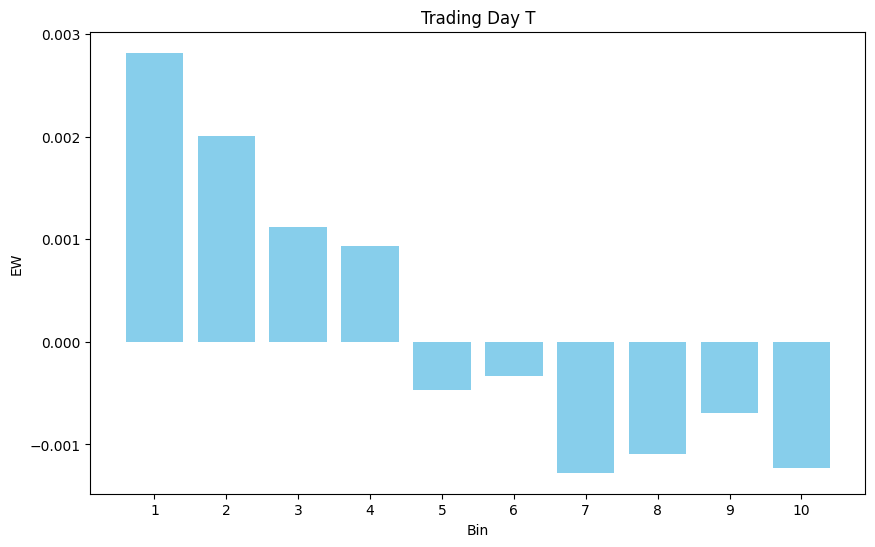

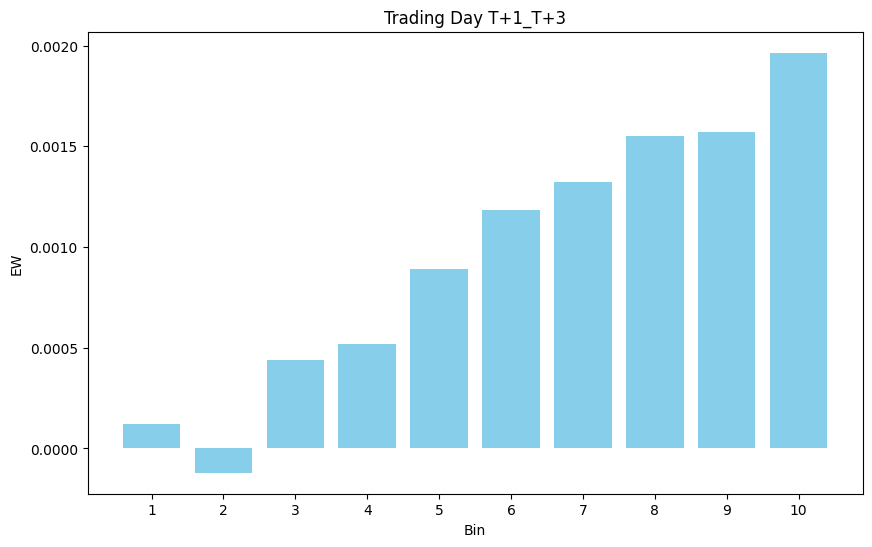

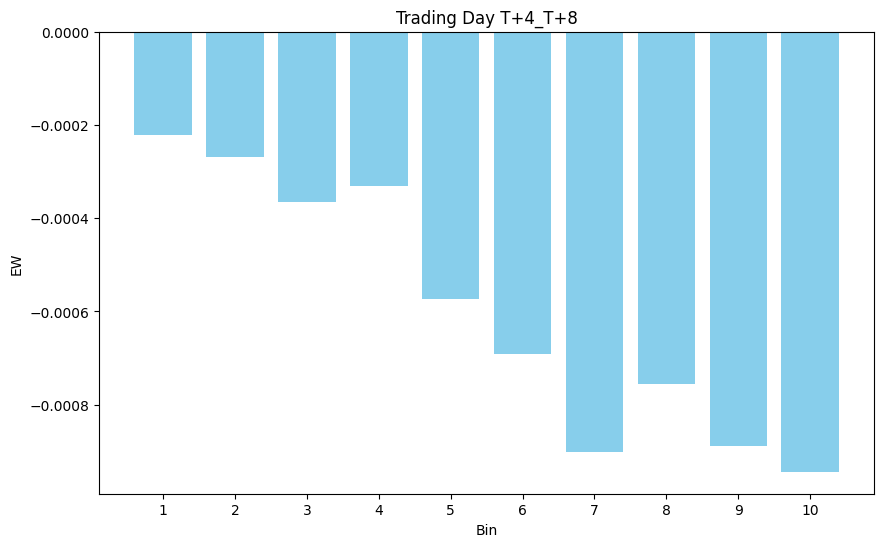

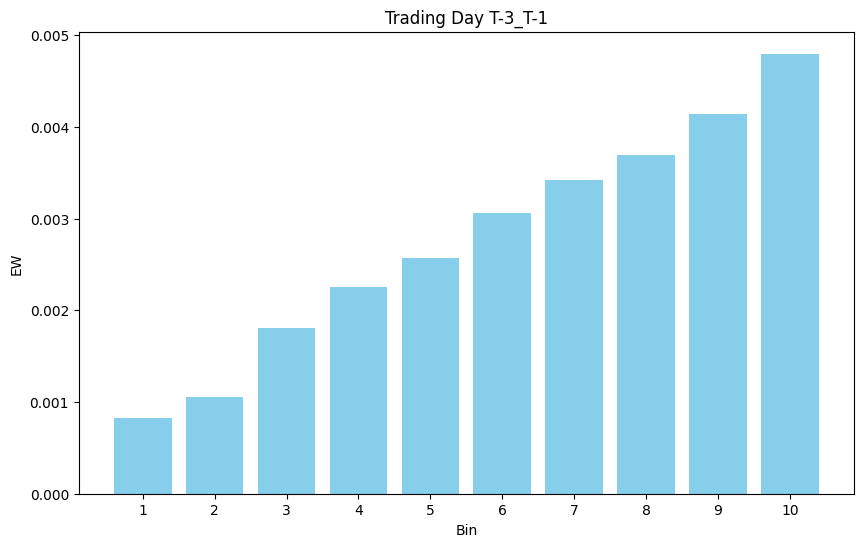

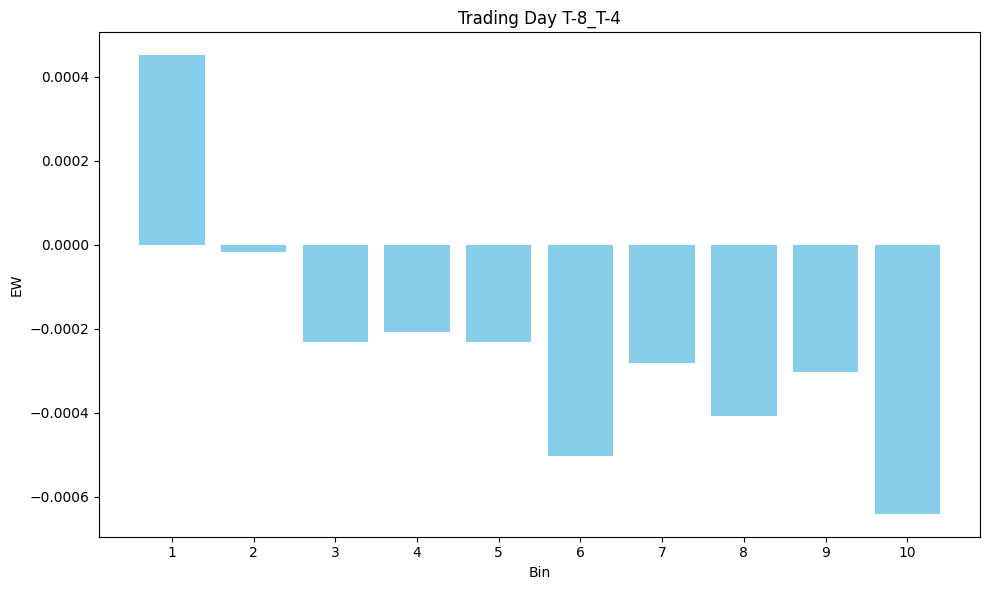

In [44]:
unique_period_label = bins['period_label'].unique()
num_days = len(unique_period_label)

# Plot each trading day
for i, day in enumerate(unique_period_label, 1):
    plt.figure(figsize=(10, 6))  # Adjust the size as needed
    day_data = bins[bins['period_label'] == day]
    plt.bar(day_data['bin'], day_data['EW'], color='skyblue')
    plt.title(f'Trading Day {day}')
    plt.xlabel('Bin')
    plt.ylabel('EW')
    plt.xticks(range(1, 11))  # Ensure bins are labeled from 1 to 10

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()